# Final Project

For my final project, I will solve the Black-Scholes equation $${\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0$$ where $V(S,t)$ is the cost of an option, $\sigma$ is volatility, $r$ is interest rate, and $S$ is the stock price.

I plan to solve this PDE using the finite difference method and a variety of implicit and explicit time integrators. I want to compare how the different integrators perform in terms of accuracy and cost. Ideally, I could take some historical data and see how effectively the Black-Scholes model compares to real data. In any case, I will solve the Black-Scholes equation with a variety of parameters to verify correctness.

What boundary and initial conditions do we have for $V(S,t)$?

For the European call option (which allows the holder to _buy_ the stock for a fixed price at a time in the future) $$C(S,0)=max(S-E,0)$$ $$C(0,t) = 0$$ $$C(S,t) = S-Ee^{-rt},\:S \rightarrow \infty$$ where $E$ is the price the holder can buy the stock for (the strike price).

The European put option (which allows the holder to _sell_ the stock for a fixed price at a time $T$ in the future) $$P(S,0)=max(E-S,0)$$ $$P(0,t) = Ee^{-rt}$$ $$P(S,t) = 0, t \rightarrow \infty$$ where $E$ is the sell price.

In [1]:
import numpy
import numpy.linalg
from matplotlib import pyplot
import math
import scipy.stats as stats
%matplotlib inline

def rk_butcher_4():
    A = numpy.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = numpy.array([[1/6, 1/3, 1/3, 1/6]])
    return A, b

def rk_butcher_bs3():
    A = numpy.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = numpy.array([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]])
    return A, b

def ode_rkexplicit(f, u0, butcher=rk_butcher_bs3, tfinal=1, h=.1):
    A, b = butcher()
    adaptive = b.shape[1] == 2
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        if adaptive:
            eloc = numpy.norm(h * fY *(b[0,:] - b[1,:]))
            ratio = (tol/eloc)**(1/order)
            if ratio > 1:
                h_next = h * ratio * .9
            else:
                h = h * ratio * .9
                continue
        u += h * fY.dot(b[0,:])
        t = tnext
        hist.append((t, u.copy()))
    return hist

# computes the derivative using the forward difference formula
# returns len(x)-1 x len(x) matrix
def diffmat(x):
    n = len(x)
    return ((numpy.eye(n-1, n, k=1) - numpy.eye(n-1, n)).T / (x[1:] - x[:-1])).T

# backwards difference
def diffmat_back(x):
    n = len(x)+1
    return (((numpy.eye(n, n, k=-1) - numpy.eye(n, n))[1:,:]).T / x).T

# computes the second derivative
# returns len(x)-2 x len(x) matrix
def diff2mat(x):
    n = len(x)
    dists = x[:-2]-x[2:]
    return diffmat_back(dists/2).dot(diffmat(x))

def blackscholes(sigma, r, init, x, left, right):
    u0 = init(x)
    d = diffmat(x)
    dd = diff2mat(x)
    def f(t, u):
        du = d @ u
        ddu = dd @ u
        ff = 0.5 * sigma**2 * x[1:-1]**2 * ddu + (r * x[:-1] * du)[1:] - (r * u)[1:-1]
        return numpy.concatenate(([left(t)], ff, [right(x[-1], t)]))
    return x, u0, f

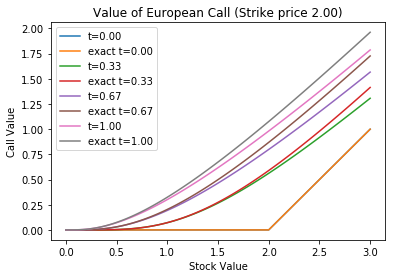

In [2]:
# for European call
strike_price = 2
init = lambda x: numpy.maximum(x-strike_price,0)
left = lambda t: 0
def right(x,t):
    return strike_price * r * math.e ** (-r*t)
sigma = 1
r = 0.5
x = numpy.linspace(0,3,num=106)
x,u0,f = blackscholes(sigma, r, init, x, left, right)
solution = ode_rkexplicit(f, u0, h=0.0001, tfinal=1)

def exact_call(xx, t):
    if t == 0:
        return numpy.maximum(xx-strike_price,0)
    else:
        s = xx.copy()
        p = xx == 0
        s[p] = 1
        d1 = 1/(sigma*math.sqrt(t)) * (numpy.log(s/strike_price)+(r+sigma**2/2)*t)
        d2 = d1 - sigma*math.sqrt(t)
        res = stats.norm.cdf(d1)*s-stats.norm.cdf(d2)*strike_price*math.e**(-r*t)
        res[p] = 0
        return res

pyplot.title("Value of European Call (Strike price %.2f)" % strike_price)
pyplot.ylabel("Call Value")
pyplot.xlabel("Stock Value")
for i in range(0, len(solution), len(solution)//3):
    t,v = solution[i]
    ex = exact_call(x,t)
    pyplot.plot(x, v, label="t=%.2f"%t)
    pyplot.plot(x, ex, label="exact t=%.2f"%t)
pyplot.legend();

The solution here does not look very good. My boundary conditions are not correct on this domain. To have correct boundary conditions, I need to extend my domain out to infinity. My solutions get better as the domain gets larger (the plot below is with a larger domain, but the same region is visable.

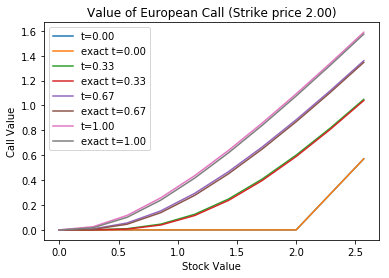

In [3]:
x = numpy.linspace(0,30,num=106)
x,u0,f = blackscholes(sigma, r, init, x, left, right)
solution = ode_rkexplicit(f, u0, h=0.0001, tfinal=1)

pyplot.title("Value of European Call (Strike price %.2f)" % strike_price)
pyplot.ylabel("Call Value")
pyplot.xlabel("Stock Value")
for i in range(0, len(solution), len(solution)//3):
    t,v = solution[i]
    ex = exact_call(x,t)
    pyplot.plot(x[:10], v[:10], label="t=%.2f"%t)
    pyplot.plot(x[:10], ex[:10], label="exact t=%.2f"%t)
pyplot.legend();

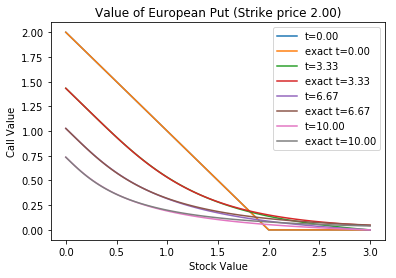

In [4]:
# for European put
strike_price = 2
r = 0.1
sigma = .3
init = lambda x: numpy.maximum(strike_price-x,0)
left = lambda t: -strike_price * r * math.e**(-r*t)
right = lambda x,t: 0
x = numpy.linspace(0,3,num=100)
x,u0,f = blackscholes(sigma, r, init, x, left, right)
solution = ode_rkexplicit(f, u0, h=0.001, tfinal=10)

def exact_put(xx, t):
    if t == 0:
        return numpy.maximum(strike_price-xx,0)
    else:
        s = xx.copy()
        p = xx == 0
        s[p] = 1
        d1 = 1/(sigma*math.sqrt(t)) * (numpy.log(s/strike_price)+(r+sigma**2/2)*t)
        d2 = d1 - sigma*math.sqrt(t)
        res = -stats.norm.cdf(-d1)*s+stats.norm.cdf(-d2)*strike_price*math.e**(-r*t)
        res[p] = strike_price * math.e ** (-r*t)
        return res

pyplot.title("Value of European Put (Strike price %.2f)" % strike_price)
pyplot.ylabel("Call Value")
pyplot.xlabel("Stock Value")
for i in range(0, len(solution), len(solution)//3):
    t,v = solution[i]
    ex = exact_put(x,t)
    pyplot.plot(x, v, label="t=%.2f"%t)
    pyplot.plot(x, ex, label="exact t=%.2f"%t)
pyplot.legend();

For the European put, there is the same issue with the call where the boundary conditions aren't quite correct. The right side of the domain is where most of the error is occuring.

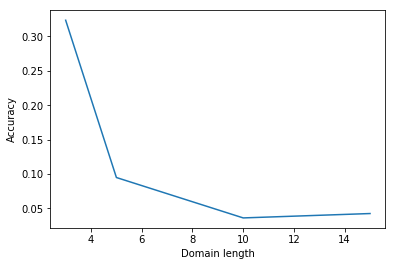

In [5]:
norms = []
sizes = [3,5,10,15]
for sz in sizes:
    x = numpy.linspace(0,sz,num=200)
    x,u0,f = blackscholes(sigma, r, init, x, left, right)
    solution = ode_rkexplicit(f, u0, h=0.0001, tfinal=10)
    ex = exact_put(x,solution[-1][0])
    norms.append(numpy.linalg.norm(ex - solution[-1][1]))

pyplot.plot(sizes,norms)
pyplot.ylabel("Accuracy")
pyplot.xlabel("Domain length");

As the domain length increases, my L2 error descrease because I get closer to the correct boundary conditions.

In [19]:
norms = []
sizes = [10,20,40,80,160,320]
for sz in sizes:
    x = numpy.linspace(0,10,num=sz)
    x,u0,f = blackscholes(sigma, r, init, x, left, right)
    solution = ode_rkexplicit(f, u0, h=0.0001, tfinal=10)
    ex = exact_put(x,solution[-1][0])
    norms.append(numpy.linalg.norm(ex - solution[-1][1]))

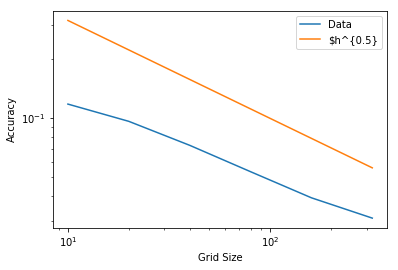

In [20]:
pyplot.loglog(sizes,norms,label="Data")
pyplot.loglog(sizes,numpy.power(sizes,-.5),label="$h^{0.5}")
pyplot.legend()
pyplot.ylabel("Accuracy")
pyplot.xlabel("Grid Size");

It looks like I have $h^{\frac 1 2}$ accuracy with a 3rd order time stepper (with adaptive timestepping).

This PDF was helpful in understanding the problem: [https://pdfs.semanticscholar.org/f8d6/efaf8585d875a133a2b8f6684447c0895f3b.pdf](https://pdfs.semanticscholar.org/f8d6/efaf8585d875a133a2b8f6684447c0895f3b.pdf)